#### Coleta de dados (Data Acquisition):

Os dados de chuva são exportados do banco de dados da (NASA)[https://power.larc.nasa.gov/api/temporal/daily/point], passando como paramentro a longitude, a latitude e as data de início e fim das coletas de dados.

Os valores retornados são:
1. PRECOT: precipitação
2. T2M: temperatura média no dia
3. RH2M: umidade do ar no dia

In [1]:
import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

In [2]:

url = "https://power.larc.nasa.gov/api/temporal/daily/point"
params = {
    "start": "19950101",
    "end": "20211231",
    "latitude": -18.215,
    "longitude": -45.2592,
    "community": "AG",
    "parameters": "PRECTOT,T2M,RH2M",
    "format": "CSV",
    "units": "metric",
    "user": "juliapereira",
    "header": "true",
    "time-standard": "lst"
}

r = requests.get(url, params=params)

In [3]:
if r.status_code == 200:
    # A resposta é CSV em texto → converter para DataFrame
    df_rain = pd.read_csv(StringIO(r.text), skiprows=11)  # pula as linhas de cabeçalho descritivo
    print(df_rain.head())
else:
    print("Erro:", r.status_code)
    print(r.text)

   YEAR  DOY    T2M   RH2M  PRECTOTCORR
0  1995    1  24.96  72.13         1.49
1  1995    2  25.49  70.76         5.15
2  1995    3  23.60  79.37         8.15
3  1995    4  22.78  84.65        20.85
4  1995    5  22.60  85.12         5.45


#### Limpeza de dados (data cleaning)

Tratar valores ausentes (NaN), zeros falsos, outliers, ajustar tipos de dados (datas), ordenar cronologicamente e remover duplicatas. É o processo de “higienizar” os dados.

Processo de limpeza:

1. **Data como index**: adicionar a data como o index do dataset dos dois dataset, de vazão e de precipitação.

2. **Valores nulos**: primeiro eliminar o que está duplicado e vazio, depois remover os demais, duplicados que tem valores mantendo ou o primeiro ou o último.

3. **Adicionar dados faltantes**: usar a interpolação para preencher lacunas na série histórica

4. **Organizar colunas e mergear datasets**: fazer o drop de colunas e renomeação para um nome mais descritivos, e juntar os dois datasets.

In [4]:
df_rain['data'] = pd.to_datetime(df_rain['YEAR'].astype(str) + df_rain['DOY'].astype(str).str.zfill(3), format='%Y%j')

df_rain = df_rain.set_index('data').sort_index()

In [5]:
df_flow = pd.read_csv('../data/raw/_vazao_rio_sao_francisco__202510062021.csv')

# Converter a coluna 'data' para datetime
df_flow['data'] = pd.to_datetime(df_flow['data_vazao'], errors='coerce')

# Definir como índice
df_flow = df_flow.set_index('data').sort_index()

df_flow

,data_vazao,vazao,codigo_bacia,codigo_sub_bacia
data,,,,
1995-01-01,1995-01-01,733.000000,4,40
1995-01-02,1995-01-02,849.000000,4,40
1995-01-03,1995-01-03,631.000000,4,40
1995-01-04,1995-01-04,675.000000,4,40
1995-01-05,1995-01-05,674.000000,4,40
...,...,...,...,...
2021-12-27,2021-12-27,947.450012,4,40
2021-12-28,2021-12-28,913.140015,4,40
2021-12-29,2021-12-29,1095.250000,4,40


In [6]:
# remove as linhas duplicadas com vazao nula
df_flow = df_flow[~(df_flow.index.duplicated(keep=False) & (df_flow['vazao'].isnull()))]
# remove o restante das duplicatas, mantendo a primeira ocorrência
df_flow.drop_duplicates(subset='data_vazao', keep='first', inplace=True)
df_flow.index.is_unique

/tmp/ipykernel_2753613/2024619776.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flow.drop_duplicates(subset='data_vazao', keep='first', inplace=True)


True

In [7]:
df_flow['vazao'] = df_flow['vazao'].interpolate(method='time')

/tmp/ipykernel_2753613/3150392176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flow['vazao'] = df_flow['vazao'].interpolate(method='time')


In [8]:
# filtrar o dataset retirando os valores nulos
df_flow['vazao'].describe()

count    9770.000000
mean      552.746443
std       362.754345
min         0.000000
25%       382.940010
50%       520.834991
75%       668.000000
max      3156.570068
Name: vazao, dtype: float64

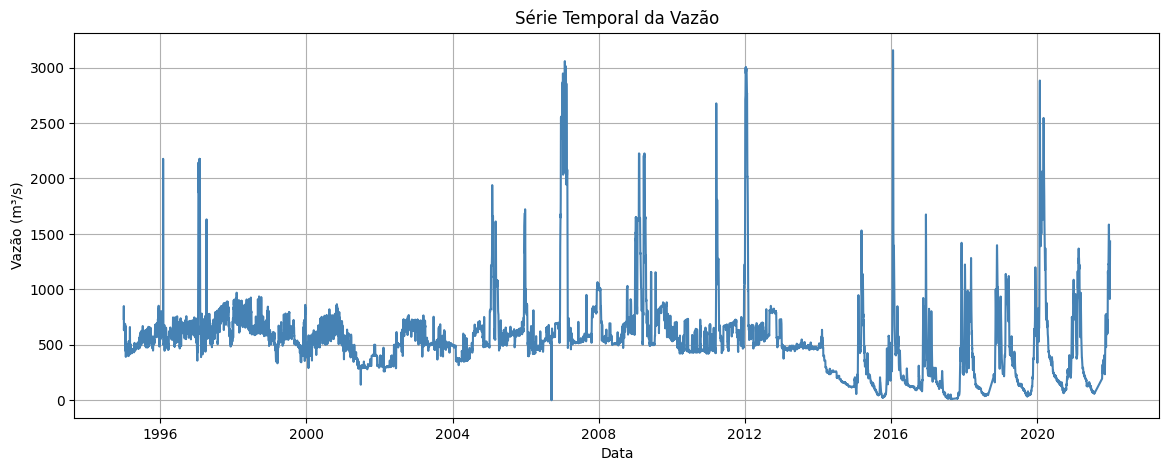

In [9]:
plt.figure(figsize=(14,5))
plt.plot(df_flow.index, df_flow['vazao'], color='steelblue')
plt.title('Série Temporal da Vazão')
plt.xlabel('Data')
plt.ylabel('Vazão (m³/s)')
plt.grid(True)
plt.show()

In [ ]:
df_flow.drop(columns=['data_vazao'], inplace=True)
df_rain.drop(columns=['YEAR', 'DOY'], inplace=True)
df_rain.rename(columns={'PRECTOTCORR': 'precipitacao', 'T2M': 'temp_media', 'RH2M': 'umidade_relativa'}, inplace=True)

/tmp/ipykernel_2753613/1459255199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flow.drop(columns=['data_vazao'], inplace=True)


In [31]:
df_merged = df_flow.merge(df_rain, how='left', on='data')

#### [WIP]Análise exploratória dos dados

In [32]:
df_merged.describe()

,vazao,codigo_bacia,codigo_sub_bacia,temp_media,umidade_relativa,precipitacao
count,9770.000000,9770.0,9770.0,9770.000000,9770.000000,9770.000000
mean,552.746443,4.0,40.0,23.667100,65.098654,2.720741
std,362.754345,0.0,0.0,2.433249,14.738880,5.567460
min,0.000000,4.0,40.0,11.910000,21.790000,0.000000
25%,382.940010,4.0,40.0,22.120000,54.272500,0.000000
50%,520.834991,4.0,40.0,23.640000,66.710000,0.130000
75%,668.000000,4.0,40.0,25.150000,77.187500,2.720000
max,3156.570068,4.0,40.0,33.250000,95.220000,62.950000


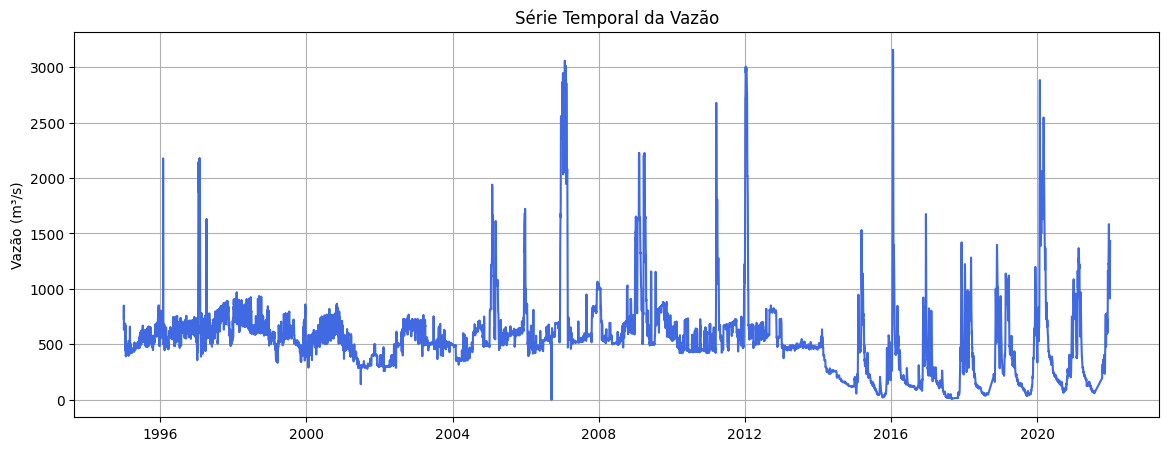

In [33]:
# série histórica da vazão

plt.figure(figsize=(14,5))
plt.plot(df_merged.index, df_merged['vazao'], color='royalblue')
plt.title('Série Temporal da Vazão')
plt.ylabel('Vazão (m³/s)')
plt.grid(True)
plt.show()

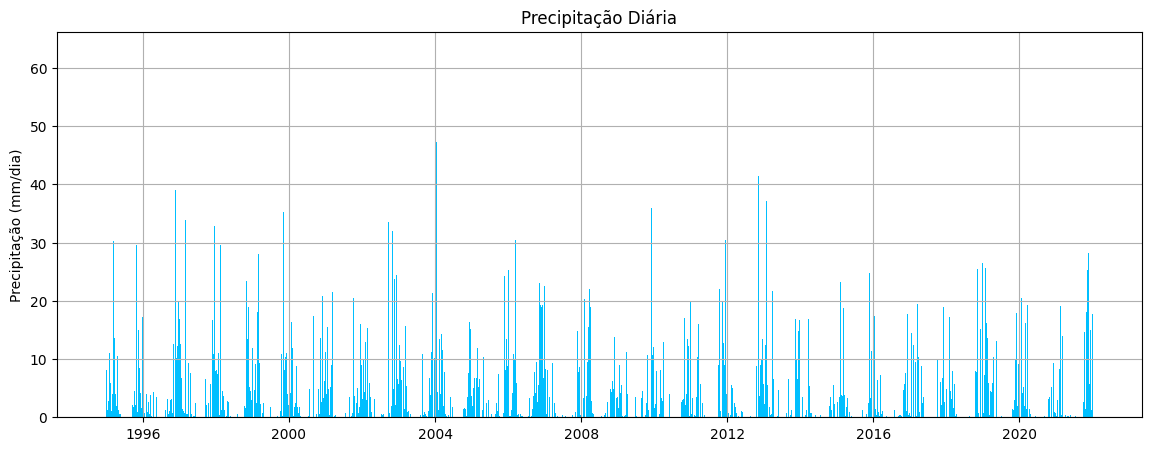

In [34]:
# série histórica da precipitação

plt.figure(figsize=(14,5))
plt.bar(df_merged.index, df_merged['precipitacao'], color='deepskyblue', width=2)
plt.title('Precipitação Diária')
plt.ylabel('Precipitação (mm/dia)')
plt.grid(True)
plt.show()

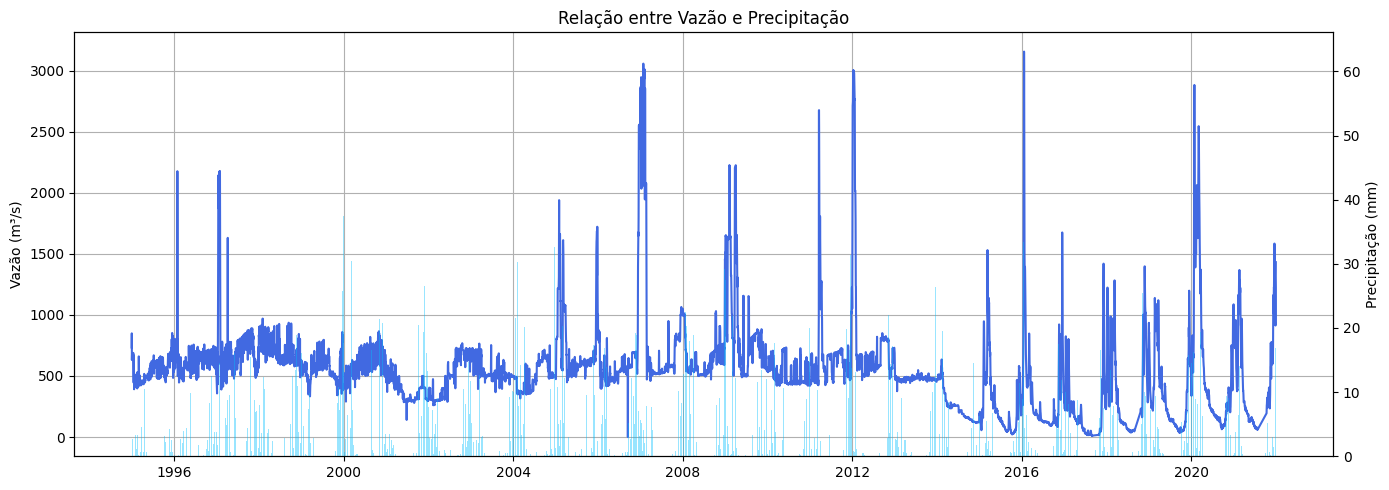

In [35]:
fig, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(df_merged.index, df_merged['vazao'], color='royalblue', label='Vazão (m³/s)')
ax2 = ax1.twinx()
ax2.bar(df_merged.index, df_merged['precipitacao'], color='deepskyblue', alpha=0.4, label='Precipitação (mm)')
ax1.set_title('Relação entre Vazão e Precipitação')
ax1.set_ylabel('Vazão (m³/s)')
ax2.set_ylabel('Precipitação (mm)')
ax1.grid(True)
fig.tight_layout()
plt.show()

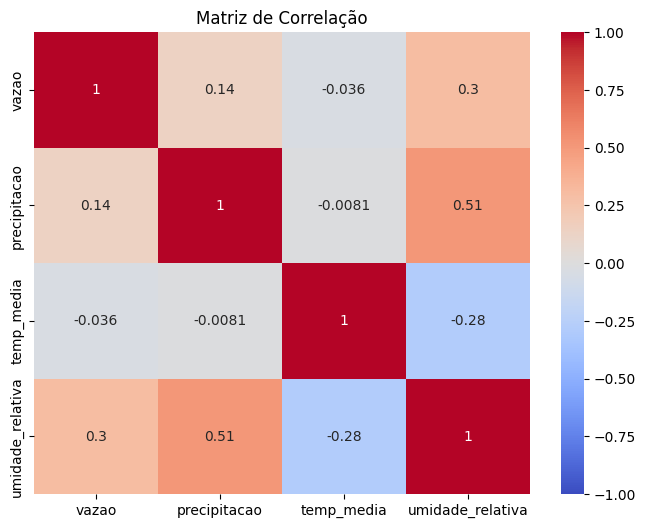

In [36]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df_merged[['vazao', 'precipitacao', 'temp_media', 'umidade_relativa']].corr(),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação')
plt.show()

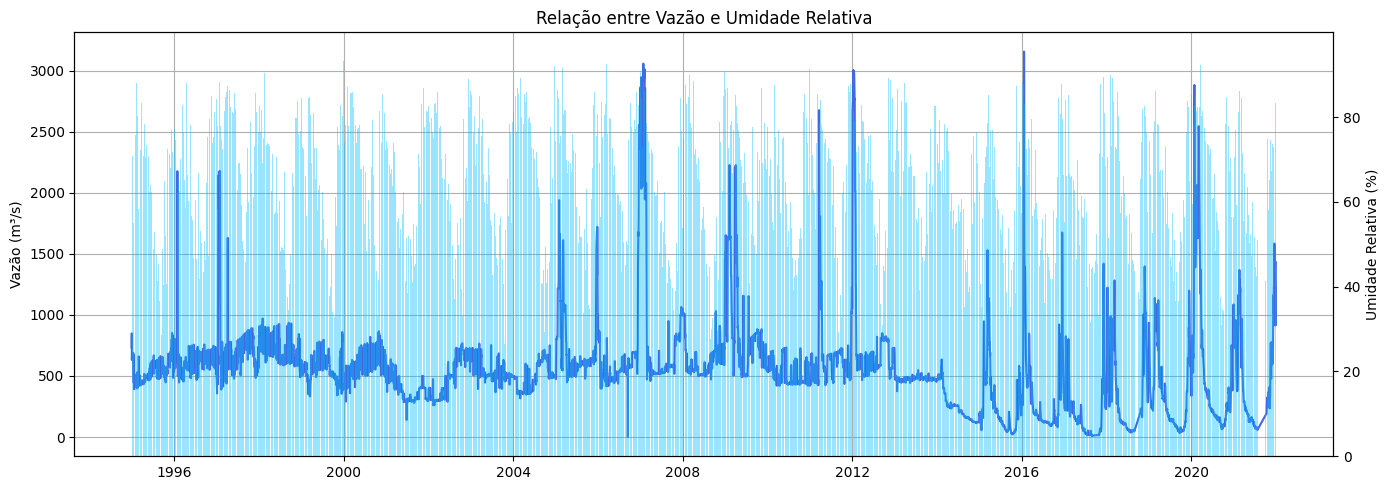

In [37]:
fig, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(df_merged.index, df_merged['vazao'], color='royalblue', label='Vazão (m³/s)')
ax2 = ax1.twinx()
ax2.bar(df_merged.index, df_merged['umidade_relativa'], color='deepskyblue', alpha=0.4, label='Umidade Relativa (%)')
ax1.set_title('Relação entre Vazão e Umidade Relativa')
ax1.set_ylabel('Vazão (m³/s)')
ax2.set_ylabel('Umidade Relativa (%)')
ax1.grid(True)
fig.tight_layout()
plt.show()

In [38]:
for lag in range(0, 11):
    corr = df_merged['vazao'].corr(df_merged['precipitacao'].shift(lag))
    print(f"Correlação chuva com lag {lag} dias: {corr:.3f}")

Correlação chuva com lag 0 dias: 0.140
Correlação chuva com lag 1 dias: 0.159
Correlação chuva com lag 2 dias: 0.180
Correlação chuva com lag 3 dias: 0.198
Correlação chuva com lag 4 dias: 0.211
Correlação chuva com lag 5 dias: 0.219
Correlação chuva com lag 6 dias: 0.221
Correlação chuva com lag 7 dias: 0.217
Correlação chuva com lag 8 dias: 0.215
Correlação chuva com lag 9 dias: 0.212
Correlação chuva com lag 10 dias: 0.208


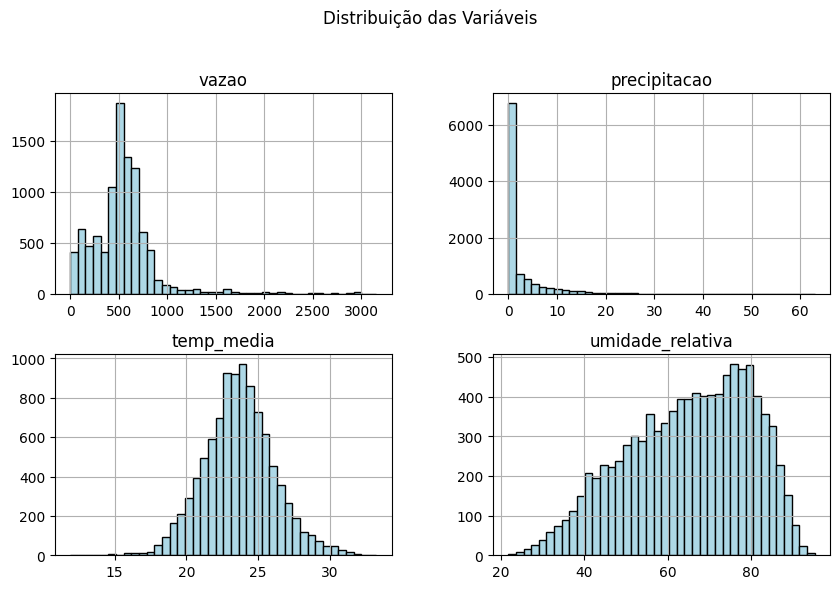

In [39]:
df_merged[['vazao', 'precipitacao', 'temp_media', 'umidade_relativa']].hist(bins=40, figsize=(10,6), color='lightblue', edgecolor='black')
plt.suptitle('Distribuição das Variáveis', y=1.02)
plt.show()

#### [WIP]Feature Engineering

In [40]:
# --- 1️⃣ Chuva acumulada e média móvel
df_merged['chuva_acum_3d'] = df_merged['precipitacao'].rolling(window=3, min_periods=1).sum()
df_merged['chuva_acum_5d'] = df_merged['precipitacao'].rolling(window=5, min_periods=1).sum()
df_merged['chuva_acum_7d'] = df_merged['precipitacao'].rolling(window=7, min_periods=1).sum()

df_merged['mes'] = df_merged.index.month
df_merged['dia'] = df_merged.index.day
df_merged['ano'] = df_merged.index.year

# --- 3️⃣ Estação do ano (para o hemisfério sul)
def get_estacao(data):
    ano = data.year
    if pd.Timestamp(ano, 3, 20) <= data < pd.Timestamp(ano, 6, 21):
        return 'outono'
    elif pd.Timestamp(ano, 6, 21) <= data < pd.Timestamp(ano, 9, 22):
        return 'inverno'
    elif pd.Timestamp(ano, 9, 22) <= data < pd.Timestamp(ano, 12, 21):
        return 'primavera'
    else:
        return 'verao'

df_merged['estacao'] = df_merged.index.map(get_estacao)

# --- 4️⃣ Converter estação para dummies (opcional, útil pra modelo ML)
df_merged = pd.get_dummies(df_merged, columns=['estacao'], prefix='estacao')

# --- 5️⃣ Verificar resultado
print(df_merged[['precipitacao', 'chuva_acum_3d', 'chuva_acum_5d', 'chuva_acum_7d', 
                 'temp_media']].head())

            precipitacao  chuva_acum_3d  chuva_acum_5d  chuva_acum_7d  \
data                                                                    
1995-01-01          1.49           1.49           1.49           1.49   
1995-01-02          5.15           6.64           6.64           6.64   
1995-01-03          8.15          14.79          14.79          14.79   
1995-01-04         20.85          34.15          35.64          35.64   
1995-01-05          5.45          34.45          41.09          41.09   

            temp_media  
data                    
1995-01-01       24.96  
1995-01-02       25.49  
1995-01-03       23.60  
1995-01-04       22.78  
1995-01-05       22.60  


In [41]:
df_merged.head()

,vazao,codigo_bacia,codigo_sub_bacia,temp_media,umidade_relativa,precipitacao,chuva_acum_3d,chuva_acum_5d,chuva_acum_7d,mes,dia,ano,estacao_inverno,estacao_outono,estacao_primavera,estacao_verao
data,,,,,,,,,,,,,,,,
1995-01-01,733.0,4,40,24.96,72.13,1.49,1.49,1.49,1.49,1,1,1995,False,False,False,True
1995-01-02,849.0,4,40,25.49,70.76,5.15,6.64,6.64,6.64,1,2,1995,False,False,False,True
1995-01-03,631.0,4,40,23.60,79.37,8.15,14.79,14.79,14.79,1,3,1995,False,False,False,True
1995-01-04,675.0,4,40,22.78,84.65,20.85,34.15,35.64,35.64,1,4,1995,False,False,False,True
1995-01-05,674.0,4,40,22.60,85.12,5.45,34.45,41.09,41.09,1,5,1995,False,False,False,True


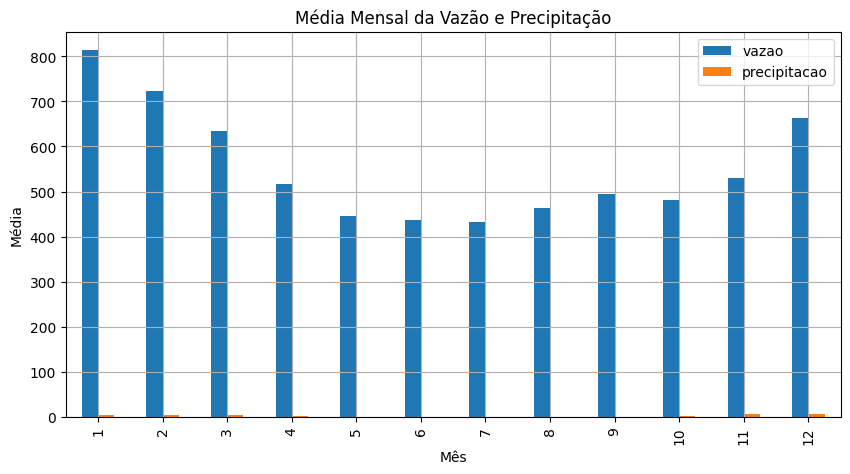

In [42]:
df_merged.groupby('mes')[['vazao', 'precipitacao']].mean().plot(kind='bar', figsize=(10,5))
plt.title('Média Mensal da Vazão e Precipitação')
plt.xlabel('Mês')
plt.ylabel('Média')
plt.grid(True)
plt.show()

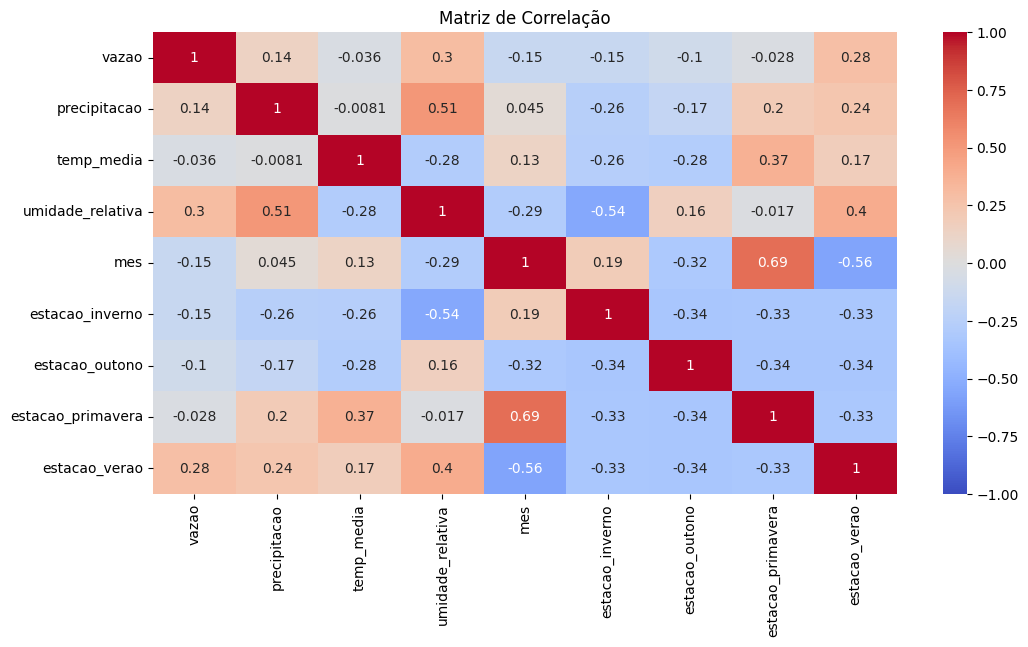

In [45]:
plt.figure(figsize=(12,6))
sns.heatmap(df_merged[['vazao', 'precipitacao', 'temp_media', 'umidade_relativa', 'mes', 'estacao_inverno', 'estacao_outono', 'estacao_primavera', 'estacao_verao']].corr(),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação')
plt.show()

In [44]:
# salvar o dataset limpo e combinado
df_merged.to_csv('../data/processed/dados_climaticos_vazao_rio_sao_francisco.csv', index=True)